In [1]:
from langchain_core.tools import tool

# Define tools
@tool
def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b


@tool
def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b


@tool
def divide(a: int, b: int) -> float:
    """Divide a and b.

    Args:
        a: first int
        b: second int
    """
    return a / b


# Augment the LLM with tools
tools = [add, multiply, divide]

In [2]:
from langchain import hub
from langchain_openai import ChatOpenAI
from langgraph.prebuilt import create_react_agent

# Choose the LLM that will drive the agent
llm = ChatOpenAI(
    model="llama3.2:3b", 
    base_url='http://localhost:11434/v1', 
    api_key='ollama')

prompt = "You are a helpful assistant."
agent_executor = create_react_agent(llm, tools, prompt=prompt)

In [3]:
agent_executor.invoke({"messages": [("user", "who is 2 plus 3")]})

{'messages': [HumanMessage(content='who is 2 plus 3', additional_kwargs={}, response_metadata={}, id='5e0e725c-f9d6-4c20-955e-aeba204adbeb'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_21ofhxc3', 'function': {'arguments': '{"a":"2","b":"3"}', 'name': 'add'}, 'type': 'function', 'index': 0}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 22, 'prompt_tokens': 331, 'total_tokens': 353, 'completion_tokens_details': None, 'prompt_tokens_details': None}, 'model_name': 'llama3.2:3b', 'system_fingerprint': 'fp_ollama', 'id': 'chatcmpl-277', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-643efe2f-8ad0-4b46-988c-2fdc79cb75e0-0', tool_calls=[{'name': 'add', 'args': {'a': '2', 'b': '3'}, 'id': 'call_21ofhxc3', 'type': 'tool_call'}], usage_metadata={'input_tokens': 331, 'output_tokens': 22, 'total_tokens': 353, 'input_token_details': {}, 'output_token_details': {}}),
  ToolMessage(content='5', name='add', id='bb6355cf-0fec-435b-8a16

In [4]:
import operator
from typing import Annotated, List, Tuple
from typing_extensions import TypedDict

class PlanExecute(TypedDict):
    input: str
    plan: List[str]
    past_steps: Annotated[List[Tuple], operator.add]
    response: str

In [5]:
from pydantic import BaseModel, Field

class Plan(BaseModel):
    """Plan to follow in future"""

    steps: List[str] = Field(
        description="different steps to follow, should be in sorted order"
    )

In [6]:
from langchain_core.prompts import ChatPromptTemplate

planner_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """For the given objective, come up with a simple step by step plan. \
This plan should involve individual tasks, that if executed correctly will yield the correct answer. Do not add any superfluous steps. \
The result of the final step should be the final answer. Make sure that each step has all the information needed - do not skip steps.""",
        ),
        ("placeholder", "{messages}"),
    ]
)

llm = ChatOpenAI(
    model="llama3.2:3b", 
    base_url='http://localhost:11434/v1', 
    api_key='ollama')

planner = planner_prompt | llm.with_structured_output(Plan)

In [7]:
planner.invoke(
    {
        "messages": [
            ("user", "what is 5 times 3?")
        ]
    }
)

Plan(steps=['Multiply 5 x 3'])

In [8]:
from typing import Union


class Response(BaseModel):
    """Response to user."""

    response: str


class Act(BaseModel):
    """Action to perform."""

    action: Union[Response, Plan] = Field(
        description="Action to perform. If you want to respond to user, use Response. "
        "If you need to further use tools to get the answer, use Plan."
    )


replanner_prompt = ChatPromptTemplate.from_template(
    """For the given objective, come up with a simple step by step plan. \
This plan should involve individual tasks, that if executed correctly will yield the correct answer. Do not add any superfluous steps. \
The result of the final step should be the final answer. Make sure that each step has all the information needed - do not skip steps.

Your objective was this:
{input}

Your original plan was this:
{plan}

You have currently done the follow steps:
{past_steps}

Update your plan accordingly. If no more steps are needed and you can return to the user, then respond with that. Otherwise, fill out the plan. Only add steps to the plan that still NEED to be done. Do not return previously done steps as part of the plan."""
)

llm = ChatOpenAI(
    model="llama3.2:3b", 
    base_url='http://localhost:11434/v1', 
    api_key='ollama')

replanner = replanner_prompt | llm.with_structured_output(Act)

In [9]:
from typing import Literal
from langgraph.graph import END


async def execute_step(state: PlanExecute):
    plan = state["plan"]
    plan_str = "\n".join(f"{i+1}. {step}" for i, step in enumerate(plan))
    task = plan[0]
    task_formatted = f"""For the following plan:
{plan_str}\n\nYou are tasked with executing step {1}, {task}."""
    agent_response = await agent_executor.ainvoke(
        {"messages": [("user", task_formatted)]}
    )
    return {
        "past_steps": [(task, agent_response["messages"][-1].content)],
    }


async def plan_step(state: PlanExecute):
    plan = await planner.ainvoke({"messages": [("user", state["input"])]})
    return {"plan": plan.steps}


async def replan_step(state: PlanExecute):
    output = await replanner.ainvoke(state)
    if isinstance(output.action, Response):
        return {"response": output.action.response}
    else:
        return {"plan": output.action.steps}


def should_end(state: PlanExecute):
    if "response" in state and state["response"]:
        return END
    else:
        return "agent"

In [10]:
from langgraph.graph import StateGraph, START

workflow = StateGraph(PlanExecute)

# Add the plan node
workflow.add_node("planner", plan_step)

# Add the execution step
workflow.add_node("agent", execute_step)

# Add a replan node
workflow.add_node("replan", replan_step)

workflow.add_edge(START, "planner")

# From plan we go to agent
workflow.add_edge("planner", "agent")

# From agent, we replan
workflow.add_edge("agent", "replan")

workflow.add_conditional_edges(
    "replan",
    # Next, we pass in the function that will determine which node is called next.
    should_end,
    ["agent", END],
)

# Finally, we compile it!
# This compiles it into a LangChain Runnable,
# meaning you can use it as you would any other runnable
app = workflow.compile()

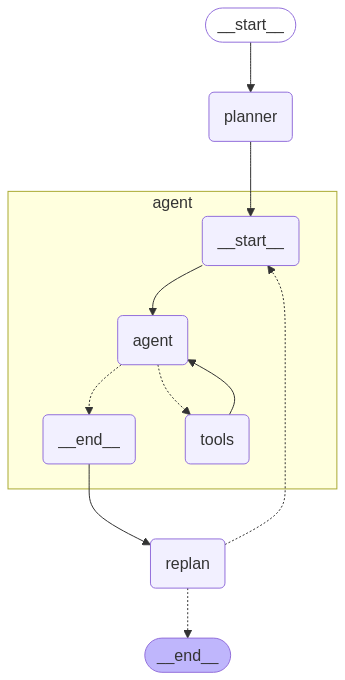

In [11]:
from IPython.display import Image, display

display(Image(app.get_graph(xray=True).draw_mermaid_png()))